# Monetary Base

In [14]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data import COUNTRIES, get_all_data_and_labels
from indicators import *
from signal_math import *
from stats import *
from utils import *

plt.rcParams["figure.figsize"] = (14, 4)

# Initialize the data
all_data, all_labels = get_all_data_and_labels()
all_data_clean, all_labels_clean = get_all_data_and_labels(cleaned=True)

for i, label in enumerate(all_labels):
    vars()[label] = all_data[i]
    
for i, label in enumerate(all_labels_clean):
    vars()[label] = all_data_clean[i]
    
print(*all_labels, sep='\n')

# Get daily returns benchmark
bond_rets_daily = bond_rets_local_fx.pct_change()

bond_rets_local_fx
equity_prices
curr_acct_nom_usd
curr_acct_pct_gdp
fx_trd_wts_nom
fx_trd_wts_real
fx_vs_usd
fx_to_usd
gdp_nom
gdp_real
short_rates
long_rates
core_cpi_sa
m1_usd
m2_usd
m3_usd
inflation_rate_annual
bond_premium
curve_height


In [15]:
m2_modified = m2_usd.copy()
m2_modified['AUS'] = (m1_usd['AUS'] + m3_usd['AUS']) / 2

m2_modified_clean = m2_usd_clean.copy()
m2_modified_clean['AUS'] = (m1_usd_clean['AUS'] + m3_usd_clean['AUS']) / 2

The prospectus claims that the percentage change in monetary base has a negative relationship with bond returns.

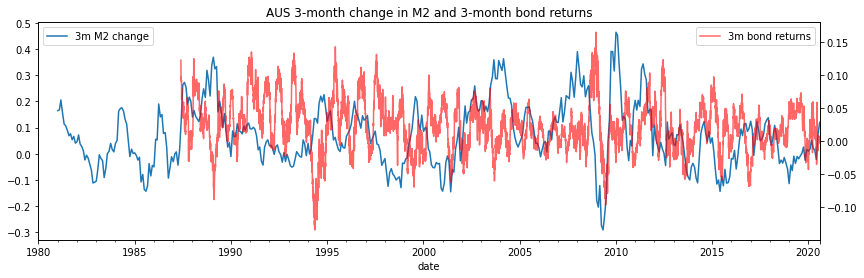

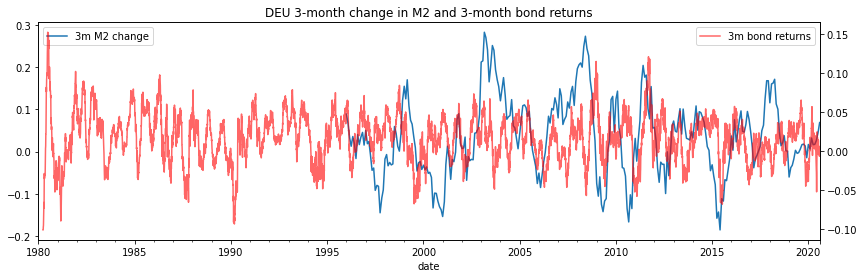

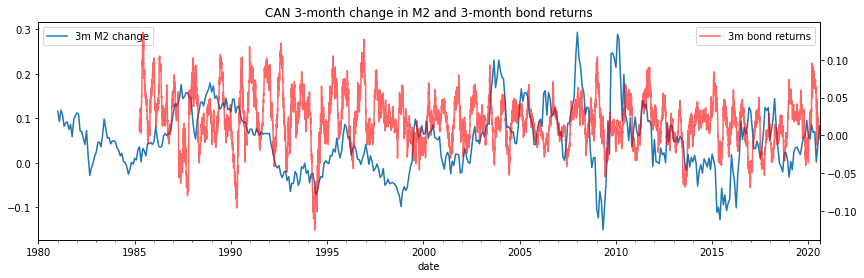

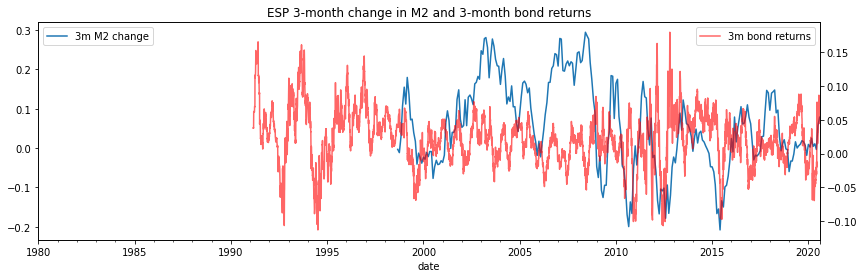

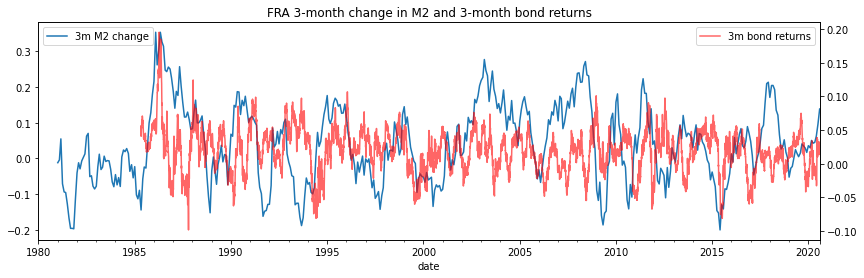

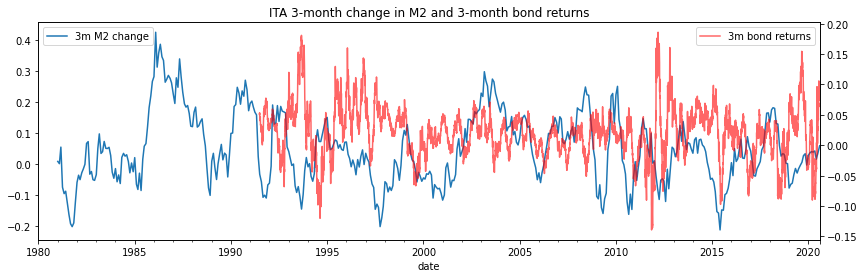

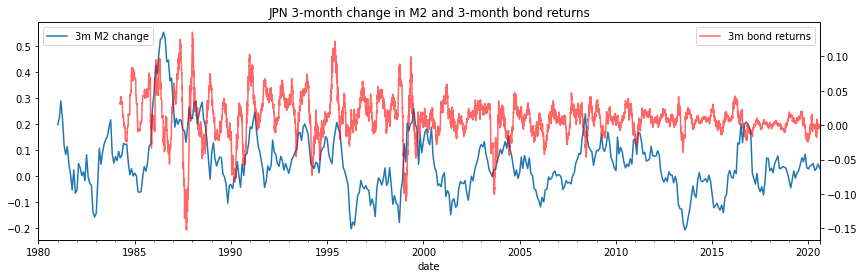

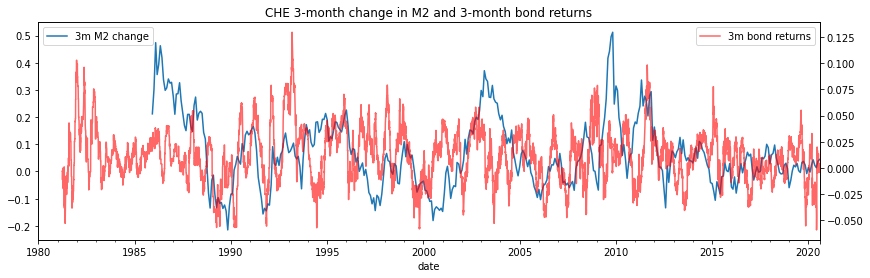

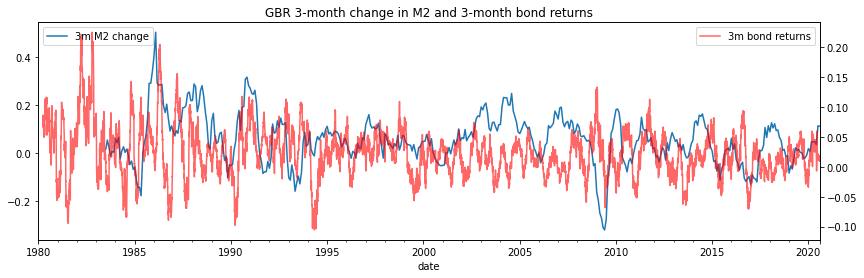

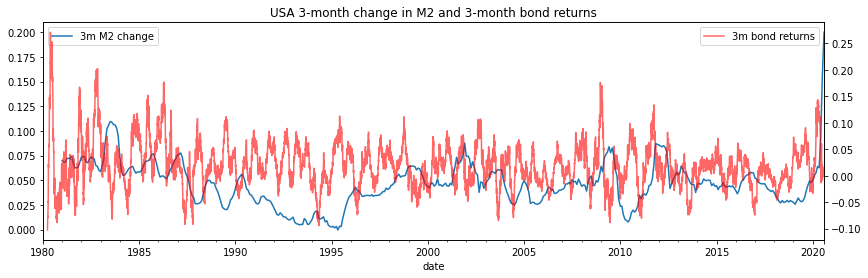

In [18]:
m2_change_3m = m2_modified.pct_change(3)
m2_change_12m = m2_modified.pct_change(12)
m2_change_growth = m2_change_12m - m2_change_3m
bond_rets_3m = bond_rets_local_fx.pct_change(3 * WEEKDAYS_PER_MONTH)
for country in bond_premium:
    fig, ax = plt.subplots()
    m2_change_growth[country].plot()
    ax2 = bond_rets_3m[country].plot(style='red', alpha=0.6, secondary_y=True)
    ax.set_title(f'{country} 3-month change in M2 and 3-month bond returns')
    ax.legend(['3m M2 change'], loc='upper left')
    ax2.legend(['3m bond returns'], loc='upper right')


## Monetary Base Indicator

Keep in mind what we are competing against:

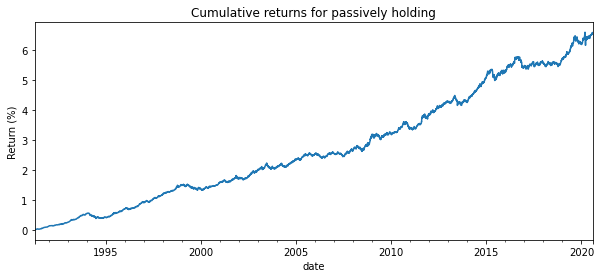

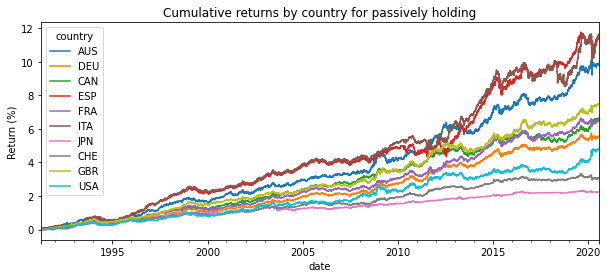

In [3]:
# Cumulative returns from holding
((1 + bond_rets_daily.dropna().mean(axis=1)).cumprod() - 1).plot(
    title='Cumulative returns for passively holding',
    ylabel='Return (%)'
)

((1 + bond_rets_daily.dropna()).cumprod() - 1).plot(
    title='Cumulative returns by country for passively holding',
    ylabel='Return (%)'
)

plt.show()

I implement the prospectus' component for monetary base as follows:

- Compute $\Delta_{3m} M_2 = \text{3-month percent change in } M_2$ <br/><br/>

- Compute $\Delta_{12m} M_2 = \text{12-month percent change in } M_2$ <br/><br/>

- The prospectus says to "compare" the two changes. Two basic types of comparisons are subtraction and division. I tried both and determined that subtraction worked better. That is, $I = \Delta_{12m} M_2 - \Delta_{3m} M_2$. <br/>
If $\Delta_{12m} M_2$ is much greater than $\Delta_{3m} M_2$, then growth should be slowing, and so interest rates may rise, and correspondingly $I$ will be bigger; and vice versa <br/><br/>

- Compute the relative indicator by subtracting the global average <br/><br/>

- Standardize that relative indicator to each country's history of the indicator



Total cumulative return: 0.09334050010463857
Cumulative return by country: country
AUS    0.289632
CAN    0.051855
CHE    0.208219
DEU    0.133316
ESP   -0.058278
FRA    0.948230
GBR   -0.073323
ITA   -0.284467
JPN   -0.201561
USA    0.140843
dtype: float64


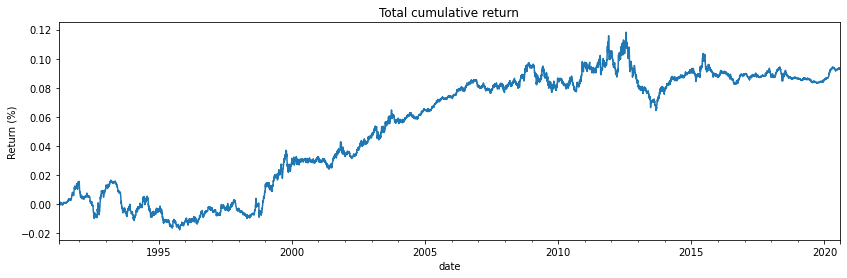

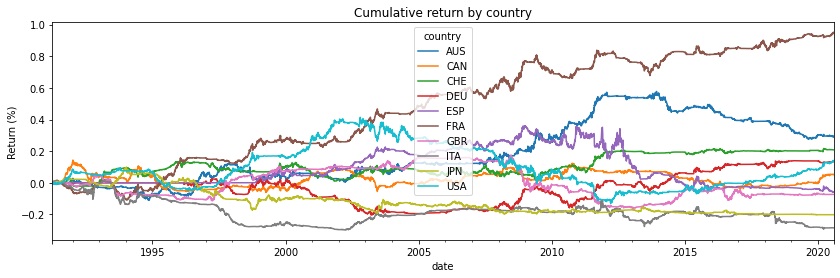

In [22]:
# Compute the signals (and indicators)
inds, sigs = test_indicator(
    monetary_base_indicator,
    index=m2_modified.index,
    data=(m2_modified,)
)

# Calculate returns
total_rets, country_rets = calculate_returns(*make_comparable(sigs, bond_rets_daily))
print('Total cumulative return:', (1 + total_rets).product() - 1)
print('Cumulative return by country:', (1 + country_rets).product() - 1)

# Plot
((1 + total_rets).cumprod() - 1).plot(
    title='Total cumulative return',
    ylabel='Return (%)'
)
((1 + country_rets).cumprod() - 1).plot(
    title='Cumulative return by country',
    ylabel='Return (%)'
)

plt.show()

Total cumulative return (denoised): 0.10370473030606564
Cumulative return by country (denoised): country
AUS    0.498290
CAN    0.094045
CHE    0.203265
DEU    0.039630
ESP   -0.064254
FRA    1.004721
GBR    0.013261
ITA   -0.282983
JPN   -0.257386
USA    0.090787
dtype: float64


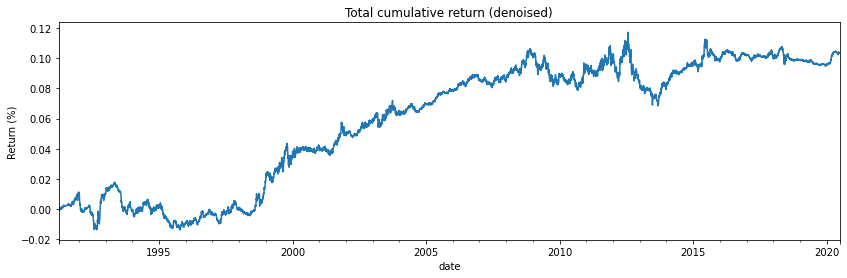

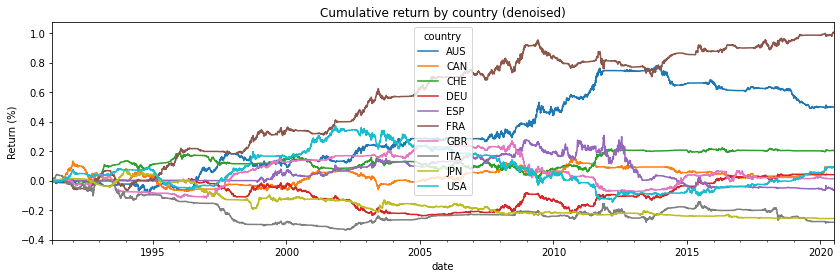

In [27]:
# Try with denoised data for fun
inds, sigs = test_indicator(
    monetary_base_indicator,
    index=m2_modified_clean.index,
    data=(m2_modified_clean,)
)

# Calculate returns
total_rets, country_rets = calculate_returns(*make_comparable(sigs, bond_rets_daily))
print('Total cumulative return (denoised):', (1 + total_rets).product() - 1)
print('Cumulative return by country (denoised):', (1 + country_rets).product() - 1)

# Plot
((1 + total_rets).cumprod() - 1).plot(
    title='Total cumulative return (denoised)',
    ylabel='Return (%)'
)
((1 + country_rets).cumprod() - 1).plot(
    title='Cumulative return by country (denoised)',
    ylabel='Return (%)'
)

plt.show()

Also pretty abysmal relative to passively holding.